# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

# План работы:
 1. Изучение данных
 2. Разбивка данных на выборки
 3. Исследование моделей
 4. Проверка лучшей модели на тестовой выборке
 5. Проверка модели на адекватность

## Откроем и изучим файл

***Импортируем необходимые нам библиотеки***

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.dummy import DummyClassifier


***Считываем файл и сохраняем его в переменную `df`***

In [2]:
#df = pd.read_csv('/datasets/users_behavior.csv')
df = pd.read_csv('https://code.s3.yandex.net/datasets/users_behavior.csv')

***Выводим на экран первые 5 строк датасета***

In [3]:
df.head()


,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


*Выведем информацию о датасете*

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


*В столбцах `calls` и `messages` указан тип данных `float`, поменяем его на `int`, так как количество звонков и смс может быть только целым числом*

In [5]:
df['calls'] = df['calls'].astype('int')
df['messages'] = df['messages'].astype('int')

***Убедимся в отсутствии пропусков***

In [6]:
df.isna().sum()

calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64

***Отлично, пропусков нет, теперь проверим наличие явных дубликатов***

In [7]:
df.duplicated().sum()

0

**Провкрим датасет на сбалансированность. Для этого посчитаем количество уникальных значений столбца `is_ultra`**

In [8]:
df['is_ultra'].value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

Мы видим большой перекос в сторону тарифа "Смарт" (значение 0)

***У нас все готово к следующему этапу. Приступим!***

## Разбивка данных на выборки

***Создадим переменную features со всеми признаками, кроме `is_ultra`.
Создадим  переменную target с целевым признаком `is_ultra`***

In [9]:
features = df.drop(['is_ultra'], axis=1)
target = df['is_ultra']

***Разделим исходные данные на обучающую, валидационную и тестовую выборки в пропорции 3:1:1***

*Сначала разделяем весь набор данных один раз для выделения обучающей выборки.*

In [10]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.4, random_state=12345, stratify = target)

*Затем разбиваем оставшиеся данные на датасеты для тестирования и валидации. Так как у нас явный перекос в сторону одного из тарифов, то воспользуемся аргументом `stratify` ,который позволит сохранить пропорции распределения в новых датасетах*

In [11]:
features_valid, features_test, target_valid, target_test = train_test_split(
    features_test, target_test, test_size=0.5, random_state=12345, stratify = target_test) #test_size равно 0,5 так как у нас равные пропорции тестовой
#и валидационной выборок

Проверим корректность разбиения

In [12]:
features_train.shape

(1928, 4)

In [13]:
features_valid.shape

(643, 4)

In [14]:
features_test.shape

(643, 4)

Данные разбиты корректно, можно приступать к моделям

## Исследование моделей

### Решающее дерево

*Рассмотрим модель обучения "решающее дерево". Попробуем разные значения одного параметра — максимальной глубины, `max_depth`. от 1 до 5 и выведем  макисмальный `Accuracy` на экран*

In [15]:
best_model_dt = None
best_result_dt = 0
train_accuracy_dt = [] #создадим списко в которой будем вносить качество модели на train датасете
valid_accuracy_dt = [] #создадим списко в которой будем вносить качество модели на validation датасете
for depth in range(1, 6):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth) # обучите модель с заданной глубиной дерева
    model.fit(features_train, target_train) # обучите модель
    predictions = model.predict(features_valid) # получите предсказания модели
    result_train = model.score(features_train, target_train)
    result = accuracy_score(target_valid, predictions) # посчитайте качество модели
    train_accuracy_dt.append(result_train)
    valid_accuracy_dt.append(result)
    if result > best_result_dt:
        best_model_dt = model
        best_result_dt = result
        
print("Accuracy лучшей модели:", best_result_dt)
print(best_model_dt)


Accuracy лучшей модели: 0.7853810264385692
DecisionTreeClassifier(max_depth=5, random_state=12345)


Построим графики, которые покажут зависимость accuracy от параметра max_depth для  на train и validation датасетов

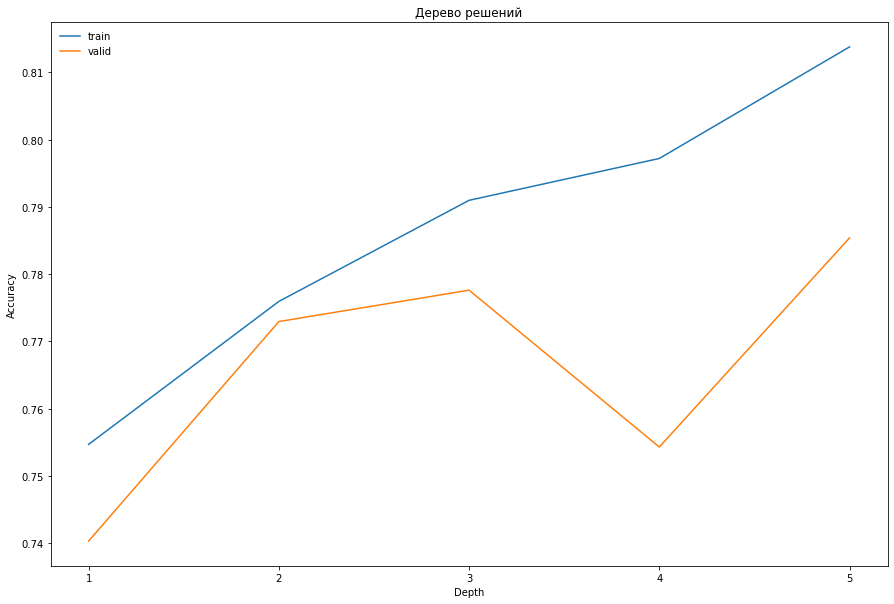

In [16]:
depth = [1,2,3,4,5]
plt.figure(figsize=(15, 10))
plt.plot(depth, train_accuracy_dt, label = 'train')
plt.plot(depth, valid_accuracy_dt, label = 'valid')
plt.legend(loc='upper left', frameon=False)
plt.xticks([1,2,3,4,5])
plt.xlabel('Depth') 
plt.ylabel('Accuracy') 
plt.title('Дерево решений')
plt.show()


Мы видим, что на тренировочном датасете точность выше, чем на validation. Еще наблюдается резкое падение точности при параметре depth = 4

### Случайный лес

*Попробуем новый алгоритм классификации — `случайный лес`. Алгоритм обучает большое количество независимых друг от друга деревьев, а потом принимает решение на основе голосования. Случайный лес помогает улучшить результат предсказания и избежать переобучения. Для построения модели возьмем следующие гипперпараметры:*
Количество деревьев `n_estimators`: от 10 до 50 с шагом 10
Макисмальная глубина `max_depth` от 0 до 10
Минимальное количество выборок, которые должен содержать внутренний узел для разделения на другие узлы `min_samples_split` от 2 до 6

In [17]:
%%time
best_model_rf = None
best_result_rf = 0

for est in range(10, 51, 10):
     for depth in range (1, 11):
            for samples_split in range (2, 7):
                model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth, min_samples_split = samples_split)
                model.fit(features_train, target_train) # обучаем модель на тренировочной выборке
                result = model.score(features_valid, target_valid) # посчитаем качество модели на валидационной выборке
                if result > best_result_rf:
                    best_model_rf = model # сохраняем наилучшую модель
                    best_result_rf =  result #  сохраняем наилучшее значение метрики accuracy на валидационных данных

print("Accuracy наилучшей модели на валидационной выборке:", best_result_rf)
print(best_model_rf)


Accuracy наилучшей модели на валидационной выборке: 0.8211508553654744
RandomForestClassifier(max_depth=9, n_estimators=40, random_state=12345)
CPU times: total: 19.1 s
Wall time: 19.2 s


### Логическая регрессия 

*Обучим модель логической регрессии и посмотрим долю правильных ответов*

In [18]:
model = LogisticRegression()

model.fit(features, target)
result = model.score(features_valid, target_valid)
print("Accuracy модели обученной лдогической регрессии:", result)

Accuracy модели обученной лдогической регрессии: 0.7418351477449455


# Мы исследовали качества трех разных моделей: решающее дерево, случайный лес и логическая регрессия. В результате лучший `accuracy` показала модель случайный лес со следующими гипперпараметрами: max_depth=10, min_samples_split=6, n_estimators=50 #

## Проверка лучшей модели на тестовой выборке

**Проверим нашу модель, которая показала наилучшие результаты на валидационной выборке, на тестовой выборке**

In [19]:
model = RandomForestClassifier(random_state=12345, n_estimators=50, max_depth=10, min_samples_split = 6)
model.fit(features_train, target_train) # обучаем модель

result = model.score(features_test, target_test) # посчитаем качество модели
print("Accuracy модели на тестовой выборке:", result)

Accuracy модели на тестовой выборке: 0.80248833592535


# Accuracy модели на тестовой выборке получился равным 0,809, что  больше, чем требуемый в задании уровень accuracy 0,75. Значит наша модель хорошо обучена и дает достаточно качественные прогнозы #

Объединим тренировочную и валидоционную выборку и обучим модель, затем проверим результат на тестовой выборке

In [20]:
features_train_2 = pd.concat([features_train, features_valid], sort = False, axis = 0)
target_train_2 = pd.concat([target_train, target_valid], sort = False, axis = 0)
model = RandomForestClassifier(random_state=12345, n_estimators=50, max_depth=10, min_samples_split = 6)
model.fit(features_train_2, target_train_2) # обучаем модель

result = model.score(features_test, target_test) # посчитаем качество модели
print("Accuracy модели на тестовой выборке:", result)

Accuracy модели на тестовой выборке: 0.833592534992224


# Точность модели получилась выше, когда мы объединили тестовую и валидационную выборки и обучили модель по ним #

## Проверка модели на адекватность

**Так как у нас явный перекос в пользу 0, то для проверки на адекватность сравним точность нашей модели с baseline моделью, которая всегда предсказывает наиболее частовстречающийся класс**

In [21]:
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=0)
dummy_clf.fit(features_train_2, target_train_2)
result_dummy = dummy_clf.score(features_test, target_test)
print("Accuracy модели на тестовой выборке:", result_dummy)

Accuracy модели на тестовой выборке: 0.6936236391912908


Мы видим, что `accuracy` этой модели менбше, чем точность той модели ,какую мы получили, значит, проверка на адекватность пройдена!